# Run Boston Harbor test case
using py_gnome

In [2]:
"""
a simple script to run GNOME

This one uses:

  - the GeoProjection
  - wind mover
  - random mover
  - cats shio mover
  - cats ossm mover
  - plain cats mover
"""

import os
from datetime import datetime, timedelta

import numpy as np

from gnome import scripting
from gnome.basic_types import datetime_value_2d

from gnome.utilities.projections import GeoProjection
from gnome.utilities.remote_data import get_datafile

from gnome.environment import Wind, Tide
from gnome.map import MapFromBNA

from gnome.model import Model
from gnome.spill import point_line_release_spill
from gnome.movers import RandomMover, WindMover, CatsMover, ComponentMover


from gnome.outputters import Renderer
from gnome.outputters import NetCDFOutput

In [3]:
# define base directory

#base_dir = os.path.dirname(__file__)
base_dir = os.getcwd()

In [4]:
def make_model(images_dir=os.path.join(base_dir, 'images')):

    # create the maps:

    print 'creating the maps'
    mapfile = get_datafile(os.path.join(base_dir, './MassBayMap.bna'))
    gnome_map = MapFromBNA(mapfile, refloat_halflife=1)  # hours

    renderer = Renderer(mapfile, images_dir, size=(800, 800),
                        projection_class=GeoProjection)

    print 'initializing the model'
    start_time = datetime(2013, 3, 12, 10, 0)

    # 15 minutes in seconds
    # Default to now, rounded to the nearest hour
    model = Model(time_step=900, start_time=start_time,
                  duration=timedelta(days=1),
                  map=gnome_map, uncertain=False)

    print 'adding outputters'
    model.outputters += renderer

    netcdf_file = os.path.join(base_dir, 'script_boston.nc')
    scripting.remove_netcdf(netcdf_file)
    model.outputters += NetCDFOutput(netcdf_file, which_data='all')

    print 'adding a RandomMover:'
    model.movers += RandomMover(diffusion_coef=100000)

    print 'adding a wind mover:'

    series = np.zeros((2, ), dtype=datetime_value_2d)
    series[0] = (start_time, (5, 180))
    series[1] = (start_time + timedelta(hours=18), (5, 180))

    w_mover = WindMover(Wind(timeseries=series, units='m/s'))
    model.movers += w_mover
    model.environment += w_mover.wind

    print 'adding a cats shio mover:'

    curr_file = get_datafile(os.path.join(base_dir, r"./EbbTides.cur"))
    tide_file = get_datafile(os.path.join(base_dir, r"./EbbTidesShio.txt"))

    c_mover = CatsMover(curr_file, tide=Tide(tide_file))

    # this is the value in the file (default)
    c_mover.scale_refpoint = (-70.8875, 42.321333)
    c_mover.scale = True
    c_mover.scale_value = -1

    model.movers += c_mover

    # TODO: cannot add this till environment base class is created
    model.environment += c_mover.tide

    print 'adding a cats ossm mover:'

    # ossm_file = get_datafile(os.path.join(base_dir,
    #                          r"./MerrimackMassCoastOSSM.txt"))
    curr_file = get_datafile(os.path.join(base_dir,
                             r"./MerrimackMassCoast.cur"))
    tide_file = get_datafile(os.path.join(base_dir,
                             r"./MerrimackMassCoastOSSM.txt"))
    c_mover = CatsMover(curr_file, tide=Tide(tide_file))

    # but do need to scale (based on river stage)

    c_mover.scale = True
    c_mover.scale_refpoint = (-70.65, 42.58333)
    c_mover.scale_value = 1.
    model.movers += c_mover
    model.environment += c_mover.tide

    print 'adding a cats mover:'

    curr_file = get_datafile(os.path.join(base_dir, r"MassBaySewage.cur"))
    c_mover = CatsMover(curr_file)

    # but do need to scale (based on river stage)

    c_mover.scale = True
    c_mover.scale_refpoint = (-70.78333, 42.39333)

    # the scale factor is 0 if user inputs no sewage outfall effects
    c_mover.scale_value = .04

    model.movers += c_mover

    # pat1Angle 315;
    # pat1Speed 19.44; pat1SpeedUnits knots;
    # pat1ScaleToValue 0.138855
    #
    # pat2Angle 225;
    # pat2Speed 19.44; pat2SpeedUnits knots;
    # pat2ScaleToValue 0.05121
    #
    # scaleBy WindStress

    print "adding a component mover:"
    component_file1 = get_datafile(os.path.join(base_dir, r"./WAC10msNW.cur"))
    component_file2 = get_datafile(os.path.join(base_dir, r"./WAC10msSW.cur"))
    comp_mover = ComponentMover(component_file1, component_file2, w_mover.wind)

    # todo: callback did not work correctly below - fix!
    # comp_mover = ComponentMover(component_file1,
    #                             component_file2,
    #                             Wind(timeseries=series, units='m/s'))

    comp_mover.scale_refpoint = (-70.855, 42.275)
    comp_mover.pat1_angle = 315
    comp_mover.pat1_speed = 19.44
    comp_mover.pat1_speed_units = 1
    comp_mover.pat1ScaleToValue = .138855
    comp_mover.pat2_angle = 225
    comp_mover.pat2_speed = 19.44
    comp_mover.pat2_speed_units = 1
    comp_mover.pat2ScaleToValue = .05121

    model.movers += comp_mover

    print 'adding a spill'

    end_time = start_time + timedelta(hours=12)
    spill = point_line_release_spill(num_elements=1000,
                                     start_position=(-70.911432,
                                                     42.369142, 0.0),
                                     release_time=start_time,
                                     end_release_time=end_time)

    model.spills += spill

    return model


if __name__ == "__main__":
    scripting.make_images_dir()
    model = make_model()
    model.full_run()

images_dir is: C:\users\rsignell\documents\github\PyGnome\py_gnome\scripts\script_boston\images
creating the maps



EbbTides.cur:      100% |###########################| Time: 0:00:00   1.39 MB/s


initializing the model
adding outputters
adding a RandomMover:
adding a wind mover:
adding a cats shio mover:
adding a cats ossm mover:

EbbTidesShio.txt:      100% |#######################| Time: 0:00:00 270.00 kB/s
MerrimackMassCoast.cur:      100% |#################| Time: 0:00:00   1.44 MB/s



adding a cats mover:

MerrimackMassCoastOSSM.txt:      100% |#############| Time: 0:00:00   4.57 MB/s



adding a component mover:

MassBaySewage.cur:      100% |######################| Time: 0:00:00   1.48 MB/s
WAC10msNW.cur:      100% |##########################| Time: 0:00:00   1.44 MB/s



adding a spill


WAC10msSW.cur:      100% |##########################| Time: 0:00:00   1.39 MB/s


In [5]:
import netCDF4

In [6]:
nc = netCDF4.Dataset('script_boston.nc')
ncv = nc.variables

In [7]:
print nc

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    comment: Particle output from the NOAA PyGnome model
    feature_type: particle_trajectory
    conventions: CF-1.6
    source: PyGnome version 0.1.1
    references: TBD
    institution: NOAA Emergency Response Division
    creation_date: 2016-01-13T11:46:16
    dimensions(sizes): time(97), data(73501), two(2), three(3)
    variables(dimensions): float64 time(time), int32 particle_count(time), float64 windage_range(data,two), float64 next_positions(data,three), uint16 spill_num(data), float64 windages(data), float64 last_water_positions(data,three), float64 longitude(data), int32 age(data), float64 depth(data), float64 mass(data), int32 windage_persist(data), float64 latitude(data), int16 status_codes(data), uint32 id(data)
    groups: mass_balance



In [13]:
# which float?
id = 0

ind = np.where(nc['id'][:]==id)
lon = nc['longitude'][ind]
lat = nc['latitude'][ind]

In [20]:
folium.__version__

'0.2.0.dev'

In [33]:
import matplotlib.pyplot as plt

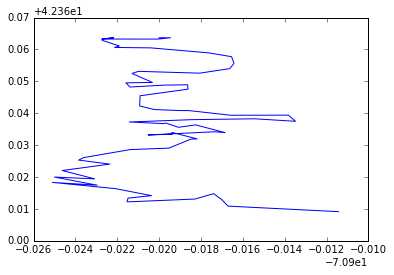

In [34]:
plt.plot(lon,lat)

In [ ]:
from IPython.display import HTML
import folium
def inline_map(map):
    """
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 510px; border: none"></iframe>'.format(srcdoc=map.HTML.replace('"', '&quot;')))

In [28]:
mapa = folium.Map(location=[lat[0],lon[0]], zoom_start=12)

n0 = folium.PolyLine(locations=[zip(lat,lon)],color='black',opacity=1.0,weight=4)
mapa.add_children(n0)

mapa

In [ ]:
import mplleaflet 
mplleaflet.display(fig=ax.figure)